In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

In [2]:
device = torch.device('cpu')

In [3]:
class QuadraticModel(nn.Module):
    def __init__(self, dims=10, scale=None, theta=None, z=None):
        super().__init__()
        if theta is not None and scale is not None:
            self.scale = scale
            self.theta = theta
            self.z = z
        else:
            scale = torch.tensor(np.random.uniform(low=0.5, high=1.5, size=(dims, dims)).astype(np.float32))
            theta = torch.tensor(np.random.uniform(low=-1, high=1, size=(dims, 1)).astype(np.float32))
            z = torch.tensor(np.random.uniform(low=-1, high=1, size=(dims, 1)).astype(np.float32))
            self.z = z.to(device)
            self.scale = scale.to(device)
            theta = theta.to(device)
            self.theta = nn.Parameter(theta)
    def forward(self):
        o = torch.matmul(self.scale, self.theta) - self.z
        o.squeeze_()
        return torch.sum(o ** 2)

In [78]:
class SGD:
    def __init__(self, lr=1e-3):
        self.lr = lr
    def __call__(self, grads):
        return -self.lr * grads
class RMSProp:
    def __init__(self, lr=1e-2, decay=0.99):
        self.lr = lr
        self.decay = decay
        self.state = None
    def __call__(self, grads):
        if self.state is None:
            self.state = torch.zeros_like(grads)
        state = self.state
        state = self.decay * state + (1 - self.decay) * torch.pow(grads, 2)
        self.state = state
        update = -self.lr * grads / (torch.sqrt(state) + 1e-6)
        return update

In [92]:
losses = {'iter': [], 'loss': [], 'optim': []}

In [93]:
for _ in range(10):
    q = QuadraticModel()
    sgd = SGD()
    for i in range(100):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('SGD')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = sgd(grads)
        q.theta.data += update
    print(y.item())

4.411057472229004
1.4877116680145264
3.1347200870513916
3.489006996154785
4.089538097381592
5.023622512817383
1.5872522592544556
5.7427473068237305
2.6918797492980957
5.492225170135498


In [94]:
for _ in range(10):
    q = QuadraticModel()
    rms = RMSProp()
    for i in range(100):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('RMSProp')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = rms(grads)
        q.theta.data += update

/Users/abdulfatir/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


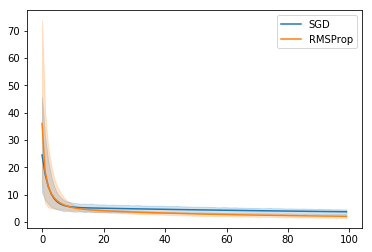

In [95]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()

In [9]:
class MetaOptimizer(nn.Module):
    def __init__(self, dim=1, hidden=20, out=1, layers=2):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden, num_layers=layers)
        self.linear = nn.Linear(hidden, out)
    def forward(self, grad, state=None):
        # seq_len x batch x size
        grad = grad.view(1, -1, 1)
        if state is None:
            h = torch.zeros(self.layers, grad.size()[1], self.hidden)
            c = torch.zeros(self.layers, grad.size()[1], self.hidden)
            h = h.to(device)
            c = c.to(device)
            state = (h, c)
        lstm_out, state = self.lstm(grad, state)
        # lstm_out.shape: seq_len x batch x hidden
        update = self.linear(lstm_out.view(-1, self.hidden))
        return update, state

In [10]:
torch.manual_seed(0)
np.random.seed(0)
meta_optimizer = MetaOptimizer()
meta_optimizer_optim = torch.optim.Adam(meta_optimizer.parameters(), lr = 1e-4)
meta_optimizer = meta_optimizer.to(device)

In [11]:
pbar = tqdm(range(500))
state = None
for k in pbar:
    q = QuadraticModel()
    state = None
    for l in range(5):
        loss = 0.
        temp_theta = 0.
        for i in range(20):
            y = q()
            loss += y
            if q.theta.grad is not None:
                q.theta.grad.zero_()
            y.backward(retain_graph=True)
            grads = q.theta.grad.detach()
            update, state = meta_optimizer(grads, state)
            update = update.view_as(q.theta.data)
            temp_theta = q.theta + update
            temp_theta.retain_grad()
            q = QuadraticModel(scale=q.scale, theta=temp_theta, z=q.z)
        state = (state[0].detach().clone(), state[1].detach().clone())
        meta_optimizer_optim.zero_grad()
        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(meta_optimizer.parameters(), 1.)
        meta_optimizer_optim.step()
    pbar.set_description('Loss: %.3f' % loss.item())

Loss: 74.854: 100%|██████████| 500/500 [23:08<00:00,  2.71s/it]    


In [96]:
meta_optimizer.eval()
for _ in range(10):
    q = QuadraticModel()
    state = None
    for i in range(100):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.cpu().numpy()))
        losses['optim'].append('L2L')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update, state = meta_optimizer(grads, state)
        update = update.view_as(q.theta.data)
        q.theta.data += update

/Users/abdulfatir/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


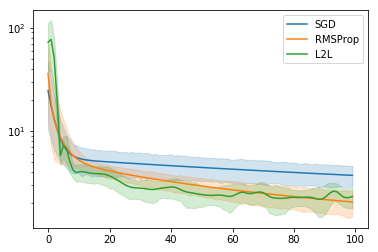

In [97]:
ax = seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
ax.set_yscale('log')
plt.show()

In [85]:
torch.save(meta_optimizer.state_dict(), 'meta-qf.pt')

/bin/zsh: can't open input file: ll


In [ ]:
df[df.optim == 'L2L'].groupby('iter').mean()

In [ ]:
df[df.optim == 'RMSProp'].groupby('iter').mean()